# 필요 라이브러리

In [28]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/project/kcure-08/lib/python3.7/site-packages')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lightgbm as lgb
import random
import sklearn
import shap


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LinearRegression
# from sklearn.impute import SimpleImputer

In [29]:
print(os.getcwd()) # 현재 경로
# print(os.listdir(os.getcwd())) # 현재 경로 파일

os.chdir('/project/kcure-08/lib/python3.7/site-packages') # 현재 경로 변경(데이터 파일)
print(os.getcwd())
# print(os.listdir(os.getcwd()))

/project/kcure-08/src/1. Data/1. Colon
/project/kcure-08/lib/python3.7/site-packages


In [30]:
# ### 데이터 모든 행, 열 확인하기
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

---

# 1. 데이터 불러오기

In [31]:
print(os.getcwd()) # 현재 경로
# print(os.listdir(os.getcwd())) # 현재 경로 파일

os.chdir('/project/kcure-08/src/1. Data/1. Colon') # 현재 경로 변경(데이터 파일)
print(os.getcwd())
# print(os.listdir(os.getcwd()))

/project/kcure-08/lib/python3.7/site-packages
/project/kcure-08/src/1. Data/1. Colon


In [32]:
### 최종 재발과 재발없는 피험자 테이블 불러오기 ###
df_cs_cc_rec = pd.read_csv('./PP_csv/cs_cc_rec_fin.csv') # 암 재발 피험자
df_cs_cc_nrec = pd.read_csv('./PP_csv/cs_cc_nrec_fin.csv') # 암 재발이 없는 피험자 (대장암 진단 이후)

In [ ]:
##### 재발여부 상관없이 데이터 합치기 
df = pd.concat([df_cs_cc_rec, df_cs_cc_nrec], ignore_index = True)
df

In [ ]:
pd.set_option('display.max_columns', None)
df.head(1)

---

# 2. 데이터 전처리하기

### 1. 불필요한 변수 제거 및 파생변수 생성
- [파생변수] : 재발시기(1년), 수술횟수, 요양식별기관(대,중도시), 흡연횟수, 알코올함량, 하루 알코올 섭취량 위험도, 신체활동량

In [7]:
df['TIME_OF_REC'].fillna('0 days', inplace = True) # NaN 값을 0 day 으로 처리 (재발없는 피험자)
df['TIME_OF_REC'] = df['TIME_OF_REC'].str.replace('days', '').astype(float).fillna(0).astype(int) # str(day)를 제거한뒤 int형으로 변환
df['TIME_OF_REC'] = pd.cut(df['TIME_OF_REC'],
                            bins = [-float('inf'), 0, 730, 1825, float('inf')],
                            labels = [0, 1, 2, 3],
                            include_lowest=True).astype(int) ## 1년단위로 범주화

In [ ]:
2년이내
3~5년이내
5년이상

In [ ]:
col_drop = ['TIME_OF_NREC_END', 'TIME_OF_REC_START', 'FDX'] # 날짜 데이터 삭제
df = df.drop(columns = col_drop)
df.head(1)

# 재발 시기 시각화

In [25]:
df['TIME_OF_REC'].value_counts()

0    21462
1      106
2       68
3       18
Name: TIME_OF_REC, dtype: int64

### 2. Null 데이터 처리 (KNN Imputer) - 결측값 대치방법

In [9]:
### df 순서변경
'''현재 칼럼명 : ['SN_KEY', 'LABEL', 'RES', 'SOPR_Y_CNT', 'TIME_OF_REC', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG', 'SEX', 'TCODE',
       'MCODE_GRP', 'GRADE', 'AGE', 'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN']'''

df = df[['SN_KEY', 'LABEL','SEX', 'AGE', 'RES', 'SOPR_Y_CNT', 'TIME_OF_REC', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE',
       'MCODE_GRP', 'GRADE',  'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN']] ### 칼럼명 변경

df.columns = ['SN_KEY', 'LABEL','SEX', 'AGE', 'CL_CD', 'SOPR_Y_CNT', 'TIME_OF_REC', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE',
       'MCODE_GRP', 'GRADE',  'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN'] ###  RES --> CL_CD

In [28]:
df.describe()

,LABEL,SEX,AGE,CL_CD,SOPR_Y_CNT,TIME_OF_REC,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
count,21654.000000,21654.000000,21654.000000,21654.000000,21654.000000,21654.000000,16464.000000,16464.000000,16464.000000,16465.000000,16424.000000,16424.000000,16263.000000,16422.000000,16424.000000,16424.000000,16423.000000,16424.000000,15797.000000,15797.000000,15711.000000,15797.000000,16424.000000,16274.000000,21654.000000,21654.000000,21654.000000,18333.000000,20413.00000,16106.000000,21214.000000,18653.000000,17643.000000,9588.000000,20413.000000,21654.000000,20718.000000,21654.000000,21214.000000,21654.000000,21654.000000,21126.000000,12685.000000,16464.000000,16020.000000,16461.000000,16455.000000,10274.000000,16470.000000,9616.000000,9766.000000,12268.000000,10643.000000,9553.000000,9859.000000,10383.000000,325.000000,731.000000,5918.000000,2461.000000,847.000000,2437.000000,341.000000,12628.000000,816.000000,12581.000000,179.000000,12631.000000,1270.000000,12604.000000,318.000000,12583.000000,175.000000,12236.000000,836.000000,11819.000000,11906.000000,11515.000000,11567.000000,11875.000000,11974.000000,11742.000000,12187.000000,12488.000000,12412.000000,12408.000000
mean,0.008959,1.399002,65.254272,0.250115,2.583957,0.013670,158.429908,58.859937,23.764699,78.664440,127.593156,77.758220,1.138966,13.673201,107.294508,26.751766,24.018450,43.474976,142.102678,52.550358,114.739164,194.648224,0.942730,84.689197,6.359010,1.071349,1.167683,44.103638,386.19179,0.419657,0.184265,0.399560,0.243836,0.389341,1.677705,0.775884,0.635438,0.691466,0.184265,0.042117,3.095133,1.707043,1.027828,1.661139,8.927135,0.162566,5.932726,0.211991,1.542441,0.036294,0.076797,0.490871,0.236306,0.028159,0.089563,0.253395,0.910769,0.956224,0.977695,0.968306,0.933884,0.780057,5.917889,0.122506,1.186275,0.048406,1.324022,0.140369,1.762992,0.065693,1.160377,0.048081,1.285714,0.117195,1.340909,1.062273,1.077020,1.003213,1.013832,1.068211,1.050693,1.000085,1.082629,1.019619,1.005076,1.003385
std,0.094230,0.489705,11.457241,0.433089,2.190621,0.157328,7.826061,10.986955,2.797727,8.394326,15.780537,10.222749,0.566343,1.870758,33.307266,19.537169,21.661226,65.598376,97.489598,16.614225,44.905434,43.220004,1.143704,27.588691,3.390849,0.453783,1.133905,31.162250,146.13074,0.493518,0.387709,0.489821,0.429407,0.487626,0.965519,0.454322,0.760931,0.485778,0.387709,0.215073,2.696060,1.242824,0.164487,0.806811,17.270969,0.595292,8.495360,0.408739,0.498211,0.187030,0.266283,0.499937,0.424832,0.165435,0.285569,0.434976,0.285516,0.204736,0.147686,0.175221,0.248631,0.414292,2.512147,0.376035,0.389567,0.276177,0.469321,0.388281,0.425415,0.305158,0.367534,0.277359,0.453050,0.368114,0.474299,0.241660,0.266634,0.056596,0.116800,0.252117,0.219380,0.009228,0.275332,0.138692,0.071066,0.058084
min,0.000000,1.000000,29.000000,0.000000,0.000000,0.000000,150.000000,40.000000,20.000000,60.000000,70.000000,40.000000,1.000000,1.800000,45.000000,4.000000,3.000000,1.000000,18.000000,6.000000,1.000000,69.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,130.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000

### 학습/검증/시험 데이터 분리

#### drop (Label)

In [ ]:
df = df.drop('LABEL', axis = 1)
df

In [12]:
### Train, Test 분할 8: 2
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='TIME_OF_REC'), df['TIME_OF_REC'], 
                                                    test_size=0.2, shuffle=True, stratify=df['TIME_OF_REC'], random_state = 42)


## Train, valid 분할 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.25, shuffle=True, stratify=y_train, random_state = 42)

In [13]:
X_train_id = X_train.pop('SN_KEY') ### key값 따로저장
X_test_id = X_test.pop('SN_KEY')
X_val_id = X_val.pop('SN_KEY')

In [14]:
imputer = KNNImputer(n_neighbors=2)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_val_imputed =  pd.DataFrame(imputer.transform(X_val), columns = X_val.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

###  3. Label encoding (이전에 이미 처리 작업진행)

###  4. 불균형 클래스 처리

<AxesSubplot:>

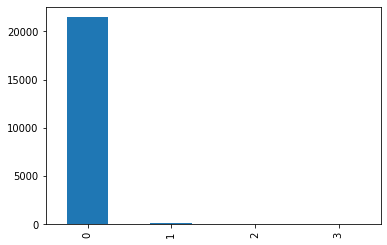

In [15]:
df['TIME_OF_REC'].value_counts().plot(kind ='bar')

In [16]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

<AxesSubplot:>

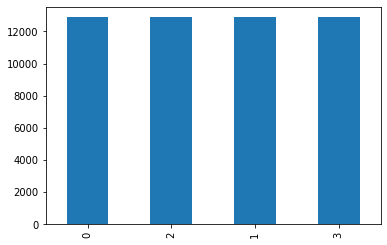

In [17]:
y_train_smote.value_counts().plot(kind ='bar')

----

# 3. 모델링

In [18]:
result = pd.DataFrame([], columns = ['acc', 'recall', 'precision', 'F1-score'])

In [19]:
## 성능 지표 계산

def result_view(model_name, pred, actual):
    acc = round(accuracy_score(actual, pred), 3)
    precision = round(precision_score(actual, pred), 3)
    recall = round(recall_score(actual, pred), 3)
    f1 = round(f1_score(actual, pred), 3)
    
    result.loc[model_name]=(acc, recall, precision, f1)
    result.sort_values(by='acc', inplace = True, ascending = True)
    
    print(result)
    plt.figure(figsize=(8,5))
    for idx in result.index:
        x_values = result.columns
        y_values = result.loc[idx]
        plt.plot(x_values, y_values)
        plt.annotate(text=round(result.loc[idx, 'acc'], 3), xy=(0, result.loc[idx, 'acc']),
                    xytext=(0, result.loc[idx, 'acc']), ha='center', fontsize=14)
        
        plt.annotate(text=round(result.loc[idx, 'recall'], 3), xy=(1, result.loc[idx, 'recall']),
                    xytext=(1, result.loc[idx, 'recall']), ha='center', fontsize=14)
        
        plt.annotate(text=round(result.loc[idx, 'precision'], 3), xy=(2, result.loc[idx, 'precision']),
                    xytext=(2, result.loc[idx, 'precision']), ha='center', fontsize=14)
        
        plt.annotate(text=round(result.loc[idx, 'F1-score'], 3), xy=(3, result.loc[idx, 'F1-score']),
                    xytext=(3, result.loc[idx, 'F1-score']), ha='center', fontsize=14)              

### 1. DNN

In [38]:
model = tf.keras.models.Sequential([
    Dense(512, activation ='relu', input_shape = (84,)),
    Dense(256, activation ='relu'),
    Dense(128, activation ='relu'),
    Dense(64, activation ='relu'),
    Dense(32, activation ='relu'),
    Dense(4, activation ='softmax'),
])

2023-12-04 16:39:46.200475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 16:39:46.201741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:01.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 16:39:46.208988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 16:39:46.209774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:01.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 16:39:46.210479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not op

In [39]:
model.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               43520     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 218,212
Trainable params: 218,212
Non-trai

In [40]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min',
                          verbose=1, patience=10)

history = model.fit(x=X_train_smote, y = y_train_smote,
              epochs = 30, batch_size = 20,
              validation_data = (X_val_imputed, y_val), verbose = 1,
              callbacks = [early_stop])

Epoch 1/30
2576/2576 [==============================] - 39s 14ms/step - loss: 0.6281 - acc: 0.7538 - val_loss: 0.4344 - val_acc: 0.8356
Epoch 2/30
2576/2576 [==============================] - 34s 13ms/step - loss: 0.2113 - acc: 0.9247 - val_loss: 0.4774 - val_acc: 0.8259
Epoch 3/30
2576/2576 [==============================] - 34s 13ms/step - loss: 0.1446 - acc: 0.9509 - val_loss: 0.1979 - val_acc: 0.9480
Epoch 4/30
2576/2576 [==============================] - 34s 13ms/step - loss: 0.1173 - acc: 0.9620 - val_loss: 0.4282 - val_acc: 0.8735
Epoch 5/30
2576/2576 [==============================] - 36s 14ms/step - loss: 0.0938 - acc: 0.9704 - val_loss: 0.2669 - val_acc: 0.9282
Epoch 6/30
2576/2576 [==============================] - 34s 13ms/step - loss: 0.0833 - acc: 0.9724 - val_loss: 0.3090 - val_acc: 0.9153
Epoch 7/30
2576/2576 [==============================] - 33s 13ms/step - loss: 0.0687 - acc: 0.9787 - val_loss: 0.1889 - val_acc: 0.9647
Epoch 8/30
2576/2576 [==========================

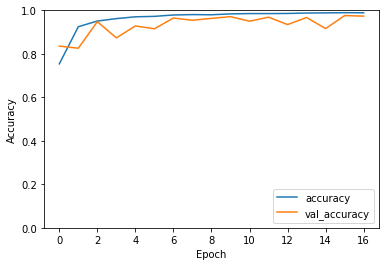

In [41]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.show()

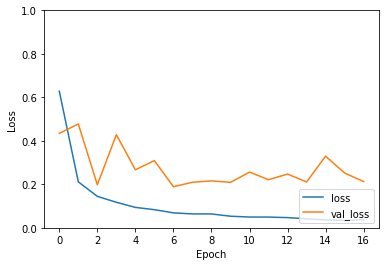

In [42]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.show()

In [43]:
y_pred = model.predict(X_test_imputed)

In [48]:
pred_class = tf.argmax(y_pred, axis=1).numpy()
proba_class = tf.reduce_max(tf.nn.softmax(y_pred), axis=1).numpy()
# proba_class

array([0.47536686, 0.47457185, 0.47536314, ..., 0.47536686, 0.4753668 ,
       0.47536537], dtype=float32)

In [44]:
y_pred

array([[1.0000000e+00, 6.9052905e-25, 1.1166240e-22, 2.2017103e-22],
       [9.9760914e-01, 5.2564232e-05, 2.0406846e-04, 2.1342325e-03],
       [9.9998879e-01, 1.9828724e-06, 1.0863348e-06, 8.1126673e-06],
       ...,
       [1.0000000e+00, 8.0492091e-10, 9.9216424e-10, 1.2686451e-11],
       [9.9999988e-01, 3.6482956e-11, 1.2703086e-07, 4.6912302e-10],
       [9.9999547e-01, 4.3332516e-06, 2.3417940e-07, 4.6295614e-08]],
      dtype=float32)

In [49]:
# y_pred_binary = (y_pred > 0.5).astype(int)
y_pred_fin = np.argmax(y_pred, axis=1)
# pd.Series(y_pred_fin).value_counts()

In [53]:
pd.Series(pred_class).value_counts()

0    4258
1      43
3      15
2      15
dtype: int64

In [56]:
print("classification Report (Binary):")
print(classification_report(y_test, y_pred_fin))

classification Report (Binary):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4292
           1       0.00      0.00      0.00        21
           2       0.07      0.07      0.07        14
           3       0.00      0.00      0.00         4

    accuracy                           0.97      4331
   macro avg       0.26      0.26      0.26      4331
weighted avg       0.98      0.97      0.98      4331



In [63]:
display(pd.crosstab(y_test, y_pred_fin))

col_0,0,1,2,3
TIME_OF_REC,,,,
0,4221,43,14,14
1,20,0,0,1
2,13,0,1,0
3,4,0,0,0


In [57]:
conf_matrix = confusion_matrix(y_test, y_pred_fin)
conf_matrix

array([[4221,   43,   14,   14],
       [  20,    0,    0,    1],
       [  13,    0,    1,    0],
       [   4,    0,    0,    0]])

In [58]:
from sklearn.metrics import roc_auc_score

In [59]:
roc_auc = roc_auc_score(y_test, y_pred_fin)
print("ROC-AUC Score:", roc_auc)

ValueError: multi_class must be in ('ovo', 'ovr')

In [60]:
fpr, tpr, th = roc_curve(y_test, y_pred_fin)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color = 'darkorange', lw=2, label=f'ROC curve (area={roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

ValueError: multiclass format is not supported

In [80]:
X_train_smote

,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
0,2.000000,71.000000,0.000000,6.000000,150.000000,50.000000,24.000000,70.000000,124.000000,74.000000,1.000000,13.900000,102.000000,19.000000,20.000000,16.000000,65.000000,53.000000,117.000000,183.000000,0.800000,77.000000,6.000000,1.0,1.000000,64.000000,500.000000,1.000000,0.00000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,1.000000,0.00000,0.000000,5.000000,3.000000,1.0,1.000000,0.000000,0.0,6.000000,0.000000,2.000000,0.0,0.0,1.000000,0.000000,1.0,1.000000,0.000000,1.0,1.0,1.000000,1.000000,1.000000,0.500000,6.500000,0.000000,1.000000,0.0,1.500000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.0,1.0,1.0,1.0,2.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
1,2.000000,68.000000,1.000000,4.000000,150.000000,60.000000,26.000000,80.000000,146.000000,86.000000,1.000000,13.700000,83.000000,22.000000,14.000000,17.000000,127.000000,52.000000,82.000000,160.000000,0.900000,67.000000,6.000000,1.0,0.000000,10.000000,160.000000,0.000000,0.00000,0.000000,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.0,5.200000,0.000000,2.000000,0.0,0.0,1.000000,0.500000,0.0,0.000000,0.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,2.500000,0.000000,1.500000,0.0,1.500000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,1.500000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
2,2.000000,73.000000,1.000000,5.000000,150.000000,50.000000,23.500000,65.000000,127.500000,78.000000,1.000000,13.300000,154.000000,17.000000,14.000000,17.000000,84.000000,64.500000,166.000000,247.500000,0.800000,76.000000,6.000000,4.0,5.000000,30.000000,652.500000,0.500000,0.50000,0.500000,0.000000,0.500000,2.500000,0.000000,1.000000,0.000000,0.50000,0.000000,8.000000,0.000000,1.0,1.000000,0.000000,0.0,23.350000,0.000000,1.500000,0.0,0.0,1.000000,0.500000,0.0,0.000000,0.000000,1.0,1.0,1.000000,1.000000,0.500000,1.000000,5.500000,0.000000,1.000000,0.0,1.500000,0.500000,1.500000,0.000000,1.500000,0.000000,1.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
3,1.000000,62.000000,0.000000,6.000000,160.000000,60.000000,23.000000,80.000000,120.000000,80.000000,1.000000,17.600000,108.000000,35.000000,20.000000,18.000000,117.000000,44.000000,166.000000,233.000000,1.000000,71.000000,6.000000,1.0,1.000000,35.000000,500.000000,1.000000,1.00000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.00000,1.000000,7.000000,0.000000,1.0,1.000000,0.000000,0.0,0.200000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,1.000000,0.500000,0.500000,0.500000,5.000000,0.000000,1.000000,0.0,1.500000,0.000000,2.000000,0.000000,1.500000,0.000000,1.500000,0.000000,2.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
4,1.000000,48.000000,0.000000,1.000000,170.000000,80.000000,26.000000,80.000000,138.000000,83.000000,1.000000,15.100000,120.000000,24.000000,19.000000,30.000000,110.000000,58.000000,95.000000,175.000000,1.000000,87.000000,10.000000,1.0,1.000000,58.000000,400.000000,1.000000,0.00000,0.000000,0.500000,0.000000,2.000000,0.000000,1.000000,0.000000,0.00000,0.0000

In [ ]:
shap.summary_plot(shap_values, X_train_smote)

### 1. Logistic Regression

In [20]:
model_lr = LogisticRegression(random_state=42, C=20, max_iter=1000)
model_lr.fit(X_train_smote, y_train_smote)

LogisticRegression(C=20, max_iter=1000, random_state=42)

In [21]:
pred_lr = model_lr.predict(X_test_imputed)

In [22]:
print("classification Report (Binary):")
print(classification_report(y_test, pred_lr))

classification Report (Binary):
              precision    recall  f1-score   support

           0       1.00      0.66      0.79      4292
           1       0.01      0.38      0.02        21
           2       0.01      0.29      0.02        14
           3       0.01      0.50      0.01         4

    accuracy                           0.66      4331
   macro avg       0.26      0.46      0.21      4331
weighted avg       0.99      0.66      0.79      4331



In [23]:
y_pred_probs = model_lr.predict_proba(X_test_imputed)

In [24]:
display(pd.crosstab(y_test, pred_lr))

col_0,0,1,2,3
TIME_OF_REC,,,,
0,2837,697,406,352
1,7,8,3,3
2,4,4,4,2
3,2,0,0,2


In [61]:
model_lr = LogisticRegression(random_state=42, C=20, max_iter=1000)
model_lr.fit(X_train_smote, y_train_smote)

LogisticRegression(C=20, max_iter=1000, random_state=42)

In [62]:
pred_lr = model_lr.predict(X_test_imputed)

In [64]:
pred_lr

array([0, 2, 3, ..., 0, 2, 0])

In [66]:
y_pred_probs = model_lr.predict_proba(X_test_imputed)

In [67]:
y_pred_probs

array([[9.95267151e-01, 4.30009360e-03, 2.00510108e-04, 2.32245618e-04],
       [4.03016642e-01, 8.54422466e-03, 5.80451001e-01, 7.98813165e-03],
       [5.04967641e-03, 1.17195563e-03, 8.14007856e-04, 9.92964360e-01],
       ...,
       [9.57144112e-01, 2.03601093e-03, 4.03767495e-02, 4.43127768e-04],
       [2.86516525e-01, 1.64711026e-02, 6.96897580e-01, 1.14792266e-04],
       [9.28103613e-01, 2.03287513e-02, 5.15047541e-02, 6.28816466e-05]])

In [70]:
display(pd.crosstab(y_test, pred_lr))

col_0,0,1,2,3
TIME_OF_REC,,,,
0,2837,697,406,352
1,7,8,3,3
2,4,4,4,2
3,2,0,0,2


In [71]:
y_test.value_counts()

0    4292
1      21
2      14
3       4
Name: TIME_OF_REC, dtype: int64

In [68]:
print("confusion Matrix:")
print(confusion_matrix(y_test, pred_lr))

confusion Matrix:
[[2837  697  406  352]
 [   7    8    3    3]
 [   4    4    4    2]
 [   2    0    0    2]]


In [73]:
from sklearn.metrics import roc_curve, auc

In [76]:
display(pd.crosstab(y_test, pred_lr))

col_0,0,1,2,3,4,5,6
TIME_OF_REC,,,,,,,
0,2088,682,379,416,203,251,273
1,3,3,2,1,1,0,0
2,2,0,4,3,1,1,1
3,0,1,2,1,2,0,1
4,0,0,1,0,1,0,2
5,0,1,0,0,0,0,1
6,0,0,1,2,0,1,0


In [65]:
result_view('Logistic Regression', pred_lr, y_test)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

### 2. KNN

In [72]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [73]:
pred_knn = model_knn.predict(X_test_imputed)

In [74]:
display(pd.crosstab(y_test, pred_knn))

col_0,0,1,2,3
TIME_OF_REC,,,,
0,3543,346,278,125
1,15,3,2,1
2,10,1,2,1
3,4,0,0,0


                       acc  recall  precision  F1-score
KNN                  0.874   0.231      0.017     0.032
Logistic Regression  0.918   0.897      0.091     0.165


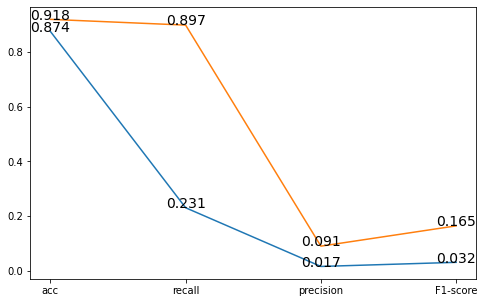

In [122]:
pred_knn = model_knn.predict(X_test_imputed)
result_view('KNN', pred_knn, y_test)

### 3. SVM

In [124]:
model_svm = SVC(random_state = 42)
model_svm.fit(X_train_smote, y_train_smote)

SVC(random_state=42)

                       acc  recall  precision  F1-score
SVM                  0.784   0.564      0.023     0.045
KNN                  0.874   0.231      0.017     0.032
Logistic Regression  0.918   0.897      0.091     0.165


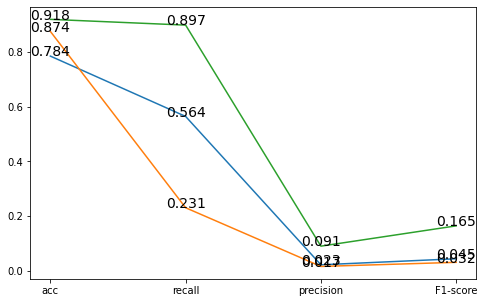

In [125]:
pred_svm = model_svm.predict(X_test_imputed)
result_view('SVM', pred_svm, y_test)

### 4. 의사결정나무

In [127]:
model_dt = DecisionTreeClassifier(min_samples_split=2,
                                 min_samples_leaf = 1,
                                 max_features = None,
                                 max_depth = 5,
                                 max_leaf_nodes = None,
                                 random_state = 21
                                 )
model_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=5, random_state=21)

                       acc  recall  precision  F1-score
SVM                  0.784   0.564      0.023     0.045
KNN                  0.874   0.231      0.017     0.032
Logistic Regression  0.918   0.897      0.091     0.165
Decision Tree        1.000   1.000      1.000     1.000


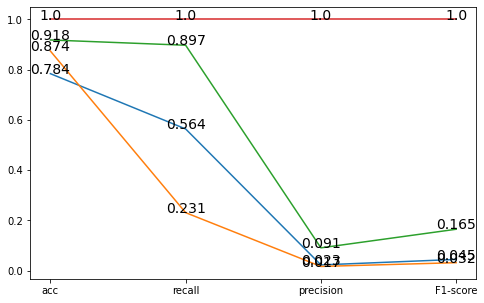

In [128]:
pred_dt = model_dt.predict(X_test_imputed)
result_view('Decision Tree', pred_dt, y_test)

### 5. 랜덤 포레스트

In [25]:
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=100,
                                 min_samples_split = 2,
                                 min_samples_leaf = 1,
                                 max_features = 'auto',
                                 max_depth = None,
                                 max_leaf_nodes=None,
                                  random_state = 42)
model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [26]:
pred_rf = model_rf.predict(X_test_imputed)
# result_view('Random Forest', pred_rf, y_test)

In [27]:
print("classification Report (Binary):")
print(classification_report(y_test, pred_rf))

classification Report (Binary):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4292
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         4

    accuracy                           0.99      4331
   macro avg       0.25      0.25      0.25      4331
weighted avg       0.98      0.99      0.99      4331



In [96]:
pred_rf

array([0, 0, 0, ..., 0, 0, 0])

In [158]:
print(model_rf.feature_importances_, '\n')

[1.06363097e-02 3.60981042e-03 3.26406161e-02 6.06155207e-02
 4.46378812e-01 6.94457893e-03 5.03789848e-03 1.64569425e-03
 4.39282873e-03 1.83917506e-03 1.79776078e-03 2.27631912e-03
 1.76126015e-03 1.67878411e-03 1.80387354e-03 1.87561241e-03
 2.55188391e-03 2.84052771e-03 1.91577023e-03 2.16471914e-03
 3.85868020e-03 3.97771059e-03 2.79629106e-03 5.75969961e-03
 9.58060071e-04 2.83191274e-03 2.78417098e-03 4.66674964e-03
 1.41353656e-02 5.56737753e-03 3.84001698e-02 2.35882002e-02
 8.80923265e-03 2.14861744e-03 8.24388444e-03 1.52687504e-02
 1.96214107e-02 6.58185061e-03 7.87595976e-04 1.36113860e-02
 9.19829826e-03 1.27267619e-03 1.64340084e-02 1.92559368e-03
 1.41584153e-03 1.47005604e-03 3.27546395e-03 1.52089427e-02
 1.52046947e-03 2.48909836e-03 6.91450326e-03 4.22411179e-03
 5.71664957e-04 2.27991482e-03 1.36897504e-02 2.95007222e-03
 1.51603748e-03 2.42097868e-04 6.89065919e-04 2.43315649e-03
 4.51342171e-03 5.04608663e-03 6.74821278e-03 7.81713608e-03
 1.44098416e-03 5.722683

In [94]:
ser = pd.Series(model_rf.feature_importances_, index=X_train.columns)
top15 = ser.sort_values(ascending = False)[:15]
print(top15)

SOPR_Y_CNT        0.070439
QC_PHX_CRA_YN     0.035094
QC_PHX_ST_ETC     0.032619
AJCC6_NEVAL       0.030069
QC_PFHX_CCR_YN    0.023588
CRTN              0.021837
LNPOS             0.021700
Q_SMK_YN          0.020861
QC_PFHX_CLV_I     0.020671
SSF1              0.020328
EXT               0.019234
QC_PFHX_ETC_I     0.018583
GRADE             0.018241
Q_PHX_TX_DM       0.017371
Q_PHX_TX_DLD      0.016908
dtype: float64


In [97]:
display(pd.crosstab(y_test, pred_rf))

col_0,0
TIME_OF_REC,
0,4292
1,21
2,14
3,4


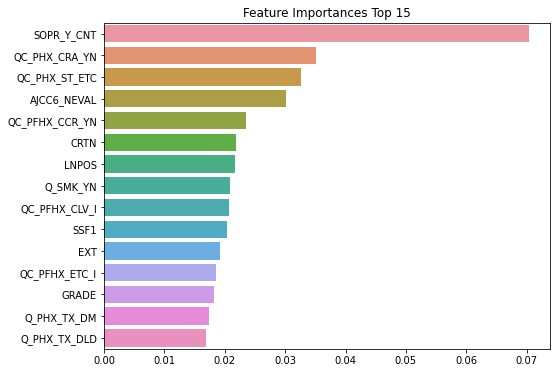

In [95]:
import seaborn as sns

plt.figure(figsize = (8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x = top15, y = top15.index)
plt.show()

In [165]:
ser = pd.Series(model_rf.feature_importances_, index=X_train.columns)
top15 = ser.sort_values(ascending = False)[:15]
print(top15)

TIME_OF_REC       0.446379
SOPR_Y_CNT        0.060616
SSF1              0.038400
CL_CD             0.032641
QC_PFHX_CCR_I     0.024597
SSF8              0.023588
AJCC6_NEVAL       0.019621
QC_PFHX_CCR_YN    0.016753
Q_SMK_YN          0.016434
QC_PFHX_CLV_I     0.016284
AJCC6_N           0.015269
Q_PHX_YN          0.015209
QC_PHX_CRA_YN     0.014837
LNPOS             0.014135
Q_PHX_DX_ETC      0.013690
dtype: float64


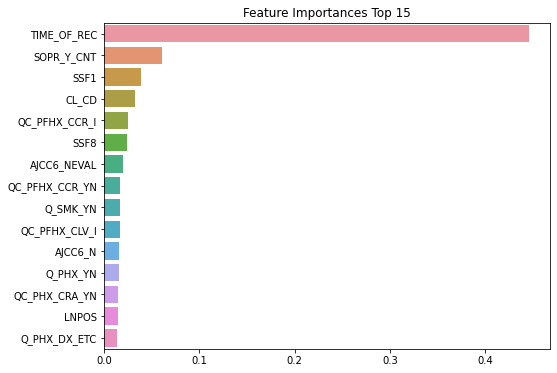

In [167]:
import seaborn as sns

plt.figure(figsize = (8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x = top15, y = top15.index)
plt.show()

### 6. XGBoost

In [146]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1,
                             n_jobs = -1,
                             n_estimators = 500,
                             random_state = 21)

In [147]:
start= time.time
eval_set = [(X_val_imputed, y_val)]

In [149]:
model_xgb.fit(X_train_smote, y_train_smote, early_stopping_rounds=10,
             eval_metric = "logloss", eval_set=eval_set, verbose=True)

# (time.time()-start)/60

[0]	validation_0-logloss:0.59823
[1]	validation_0-logloss:0.52049
[2]	validation_0-logloss:0.45566
[3]	validation_0-logloss:0.40087
[4]	validation_0-logloss:0.35406
[5]	validation_0-logloss:0.31374
[6]	validation_0-logloss:0.27878
[7]	validation_0-logloss:0.24828
[8]	validation_0-logloss:0.22156
[9]	validation_0-logloss:0.19805
[10]	validation_0-logloss:0.17731
[11]	validation_0-logloss:0.15894
[12]	validation_0-logloss:0.14264
[13]	validation_0-logloss:0.12815
[14]	validation_0-logloss:0.11523
[15]	validation_0-logloss:0.10371
[16]	validation_0-logloss:0.09340
[17]	validation_0-logloss:0.08419
[18]	validation_0-logloss:0.07593
[19]	validation_0-logloss:0.06852
[20]	validation_0-logloss:0.06188
[21]	validation_0-logloss:0.05591
[22]	validation_0-logloss:0.05054
[23]	validation_0-logloss:0.04572
[24]	validation_0-logloss:0.04138
[25]	validation_0-logloss:0.03747
[26]	validation_0-logloss:0.03395
[27]	validation_0-logloss:0.03078
[28]	validation_0-logloss:0.02792
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=21,
              reg_alpha=0, reg_lambda=1, ...)

                       acc  recall  precision  F1-score
SVM                  0.784   0.564      0.023     0.045
KNN                  0.874   0.231      0.017     0.032
Logistic Regression  0.918   0.897      0.091     0.165
Decision Tree        1.000   1.000      1.000     1.000
Random Forest        1.000   0.974      1.000     0.987
XGBoost              1.000   1.000      1.000     1.000


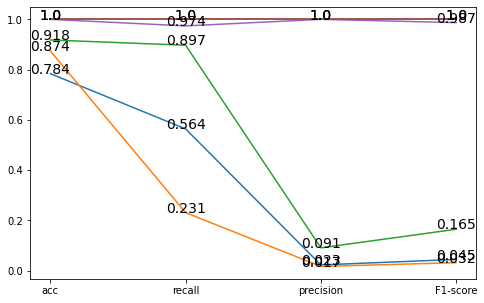

In [170]:
pred_xgb = model_xgb.predict(X_test_imputed)
result_view('XGBoost', pred_xgb, y_test)

### 7. CatBoost

In [156]:
start = time.time()

In [157]:
cat = CatBoostClassifier(learning_rate=0.03,
                        iterations=2000,
                        random_state=42)

In [169]:
start = time.time()

train_dataset = Pool(data=X_train_smote, label = y_train_smote)
eval_dataset = Pool(data=X_val_imputed, label = y_val)

cat.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds = 30)
(time.time()-start)/60

0:	learn: 0.5946416	test: 0.5976083	best: 0.5976083 (0)	total: 58.5ms	remaining: 1m 56s
1:	learn: 0.5033464	test: 0.5099139	best: 0.5099139 (1)	total: 65.3ms	remaining: 1m 5s
2:	learn: 0.4204662	test: 0.4230765	best: 0.4230765 (2)	total: 71.7ms	remaining: 47.7s
3:	learn: 0.3602885	test: 0.3693897	best: 0.3693897 (3)	total: 78.3ms	remaining: 39.1s
4:	learn: 0.3059149	test: 0.3253829	best: 0.3253829 (4)	total: 84.2ms	remaining: 33.6s
5:	learn: 0.2578844	test: 0.2745869	best: 0.2745869 (5)	total: 90.5ms	remaining: 30.1s
6:	learn: 0.2196961	test: 0.2345671	best: 0.2345671 (6)	total: 97.2ms	remaining: 27.7s
7:	learn: 0.1864809	test: 0.1990374	best: 0.1990374 (7)	total: 104ms	remaining: 25.8s
8:	learn: 0.1564958	test: 0.1675462	best: 0.1675462 (8)	total: 110ms	remaining: 24.3s
9:	learn: 0.1324633	test: 0.1421818	best: 0.1421818 (9)	total: 116ms	remaining: 23.1s
10:	learn: 0.1130947	test: 0.1213829	best: 0.1213829 (10)	total: 123ms	remaining: 22.2s
11:	learn: 0.0961445	test: 0.1035970	best: 0

99:	learn: 0.0003398	test: 0.0022295	best: 0.0022295 (99)	total: 663ms	remaining: 12.6s
100:	learn: 0.0003398	test: 0.0022295	best: 0.0022295 (100)	total: 668ms	remaining: 12.6s
101:	learn: 0.0003328	test: 0.0022296	best: 0.0022295 (100)	total: 674ms	remaining: 12.5s
102:	learn: 0.0003235	test: 0.0022316	best: 0.0022295 (100)	total: 680ms	remaining: 12.5s
103:	learn: 0.0003124	test: 0.0022333	best: 0.0022295 (100)	total: 686ms	remaining: 12.5s
104:	learn: 0.0003066	test: 0.0022338	best: 0.0022295 (100)	total: 692ms	remaining: 12.5s
105:	learn: 0.0003066	test: 0.0022338	best: 0.0022295 (100)	total: 697ms	remaining: 12.5s
106:	learn: 0.0003066	test: 0.0022338	best: 0.0022295 (100)	total: 703ms	remaining: 12.4s
107:	learn: 0.0002976	test: 0.0022366	best: 0.0022295 (100)	total: 709ms	remaining: 12.4s
108:	learn: 0.0002976	test: 0.0022366	best: 0.0022295 (100)	total: 714ms	remaining: 12.4s
109:	learn: 0.0002976	test: 0.0022366	best: 0.0022295 (100)	total: 719ms	remaining: 12.4s
110:	learn: 

0.014899885654449463

                       acc  recall  precision  F1-score
SVM                  0.784   0.564      0.023     0.045
KNN                  0.874   0.231      0.017     0.032
Logistic Regression  0.918   0.897      0.091     0.165
Decision Tree        1.000   1.000      1.000     1.000
Random Forest        1.000   0.974      1.000     0.987
XGBoost              1.000   1.000      1.000     1.000
Cat Boost            1.000   1.000      1.000     1.000


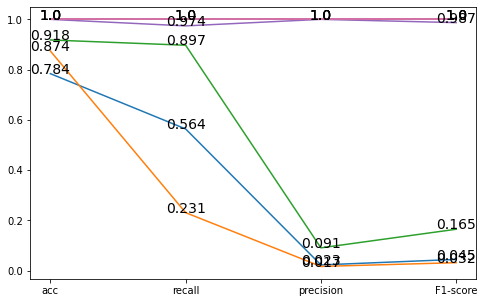

In [171]:
pred_cat = cat.predict(X_test_imputed)
result_view('Cat Boost', pred_cat, y_test)

### 8. DNN

In [274]:
dnn = tf.keras.models.Sequential([
    Dense(512, activation ='relu', input_shape = (85,)),
    Dense(256, activation ='relu'),
    Dense(128, activation ='relu'),
    Dense(64, activation ='relu'),
    Dense(32, activation ='relu'),
    Dense(2, activation ='softmax'),
])

In [275]:
dnn.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

In [276]:
checkpoint_path = 'my_checkpoint.ckpt'
check_point = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              save_best_only = True,
                              monitor = 'vale_loss',
                              verbose = 1)

In [277]:
history = dnn.fit(x=X_train_smote, y = y_train_smote,
              epochs = 50, batch_size = 20,
              validation_data = (X_val_imputed, y_val), verbose = 1,
              callbacks = [check_point])

Epoch 1/50
1288/1288 [==============================] - 21s 16ms/step - loss: 0.4178 - acc: 0.8505 - val_loss: 0.1404 - val_acc: 0.9490
Epoch 2/50
1288/1288 [==============================] - 21s 16ms/step - loss: 0.0627 - acc: 0.9784 - val_loss: 0.0196 - val_acc: 0.9961
Epoch 3/50
1288/1288 [==============================] - 20s 16ms/step - loss: 0.0269 - acc: 0.9906 - val_loss: 0.0157 - val_acc: 0.9975
Epoch 4/50
1288/1288 [==============================] - 20s 16ms/step - loss: 0.0551 - acc: 0.9832 - val_loss: 0.0202 - val_acc: 0.9975
Epoch 5/50
1288/1288 [==============================] - 20s 16ms/step - loss: 0.0442 - acc: 0.9863 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 6/50
1288/1288 [==============================] - 21s 17ms/step - loss: 0.0234 - acc: 0.9923 - val_loss: 0.0168 - val_acc: 0.9972
Epoch 7/50
1288/1288 [==============================] - 21s 16ms/step - loss: 0.0197 - acc: 0.9939 - val_loss: 0.2454 - val_acc: 0.9370
Epoch 8/50
1288/1288 [==========================

1288/1288 [==============================] - 21s 16ms/step - loss: 0.0139 - acc: 0.9970 - val_loss: 0.0086 - val_acc: 0.9986
Epoch 29/50
1288/1288 [==============================] - 21s 16ms/step - loss: 0.0098 - acc: 0.9972 - val_loss: 0.0082 - val_acc: 0.9988
Epoch 30/50
1288/1288 [==============================] - 21s 16ms/step - loss: 0.0040 - acc: 0.9987 - val_loss: 0.0140 - val_acc: 0.9986
Epoch 31/50
1288/1288 [==============================] - 22s 17ms/step - loss: 0.0059 - acc: 0.9979 - val_loss: 0.0129 - val_acc: 0.9988
Epoch 32/50
1288/1288 [==============================] - 21s 16ms/step - loss: 0.0154 - acc: 0.9969 - val_loss: 0.0187 - val_acc: 0.9988
Epoch 33/50
1288/1288 [==============================] - 21s 16ms/step - loss: 4.3467e-04 - acc: 0.9999 - val_loss: 0.0116 - val_acc: 0.9991
Epoch 34/50
1288/1288 [==============================] - 21s 17ms/step - loss: 2.1762e-06 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9991
Epoch 35/50
1288/1288 [======================

In [281]:
dnn.load_weights(checkpoint_path)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for my_checkpoint.ckpt

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

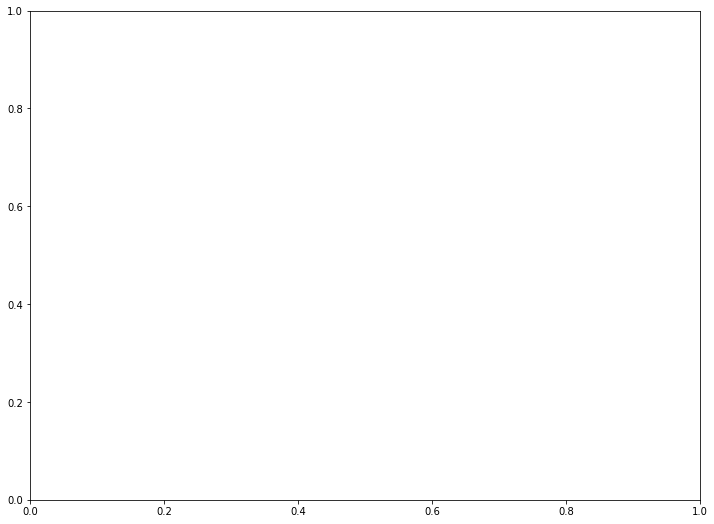

In [282]:
plt.figure(figsize= (12, 9))
plt.plot(np.arange(1, 21), history.history['loss'])
plt.plot(np.arange(1, 21), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize= (12, 9))
plt.plot(np.arange(1, 21), history.history['acc'])
plt.plot(np.arange(1, 21), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()

-------

In [267]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
dnn = Sequential()
dnn.add(Dense(512, activation ='relu', input_shape = (85,), kernel_initializer = initializer))
# dnn.add(Dropout(0.2))
dnn.add(Dense(256, activation = 'relu'))
# dnn.add(Dropout(0.2))
dnn.add(Dense(128, activation = 'relu'))
dnn.add(Dense(64, activation = 'relu'))
dnn.add(Dense(32, activation = 'relu'))
dnn.add(Dense(3, activation = 'softmax')) 
dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               44032     
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 218,691
Trainable params: 218,691
Non-tr

In [268]:
dnn.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [270]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min',
                          verbose=1, patience=5)

check_point = ModelCheckpoint('best_model.h5', verbose=1,
                             monitor='val_loss', mode='min', save_best_only=True)


hist = dnn.fit(x=X_train_smote, y = y_train_smote,
              epochs = 50, batch_size=20,
              validation_data = (X_val_imputed, y_val), verbose = 1,
              callbacks = [early_stop, check_point])

Epoch 1/50
1287/1288 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8504
Epoch 1: val_loss improved from inf to 0.08017, saving model to best_model.h5
1288/1288 [==============================] - 20s 15ms/step - loss: 0.3782 - accuracy: 0.8504 - val_loss: 0.0802 - val_accuracy: 0.9866
Epoch 2/50
1286/1288 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9690
Epoch 2: val_loss did not improve from 0.08017
1288/1288 [==============================] - 20s 15ms/step - loss: 0.1146 - accuracy: 0.9689 - val_loss: 0.1705 - val_accuracy: 0.9384
Epoch 3/50
1287/1288 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9883
Epoch 3: val_loss improved from 0.08017 to 0.02944, saving model to best_model.h5
1288/1288 [==============================] - 20s 16ms/step - loss: 0.0329 - accuracy: 0.9883 - val_loss: 0.0294 - val_accuracy: 0.9956
Epoch 4/50
1284/1288 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.9

-----

                       acc  recall  precision  F1-score
SVM                  0.784   0.564      0.023     0.045
KNN                  0.874   0.231      0.017     0.032
Logistic Regression  0.918   0.897      0.091     0.165
DNN                  1.000   1.000      0.951     0.975
Decision Tree        1.000   1.000      1.000     1.000
Random Forest        1.000   0.974      1.000     0.987
XGBoost              1.000   1.000      1.000     1.000
Cat Boost            1.000   1.000      1.000     1.000


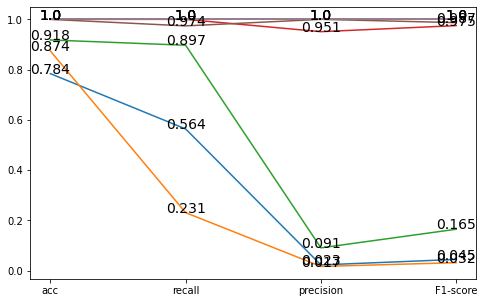

In [293]:
pred_dnn = dnn.predict(X_test_imputed)
pred_dnn = np.where(pred_dnn[:, 0] > pred_dnn[:, 1], 0, 1)
result_view('DNN', pred_dnn, y_test)

----

In [247]:
def show_confusion_matrix(labels, y_true, y_pred, title):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt = 'd', xticklabels = labels, yticklabels=labels,
               cmap=plt.cm.Blues, linecolor='black')
    plt.text(1,2.3, 'Predicted', size=15, ha='center')
    plt.text(-0.3,1, 'True', rotation=90, size=15, ha='center')
    plt.title(title)
    plt.show

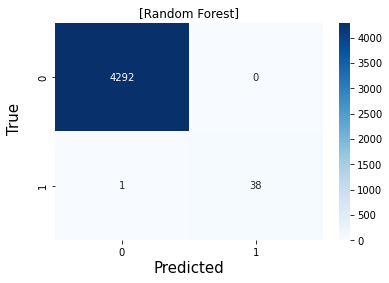

In [255]:
labels= [0, 1]
# show_confusion_matrix(labels, y_test, pred_cat, '[CatBoost]')
show_confusion_matrix(labels, y_test, pred_rf, '[Random Forest]')

In [263]:
def plot_multicalss_roc(y_pred, y_true, y_label):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
    
    for i in range(len(y_label)):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        fig, ax = plt.subplots(figsize=(17, 10))
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic example')
        for i in range(len(y_label)):
            ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s ' % (roc_auc[i], y_lable[i]))
            ax.legend(loc = 'best')
            ax.grid(alpha=.4)
            sns.despine()
            plt.show()


[1] 재발 위험도 분석
- 전체 학습으로 재발율 1로 예측한 피험자의 확률값을 가지고 위험도를 나눈다.
- 예후인자

[2] 재발시기 예측
- 재발시기를 label로 시기를 예측하기(재발피험자 대상)
- 예후인자 

[3] 건강행태 예후인자
- 건강행태 변수들로 피험자의 유의미한 지표 추출

[4] 원발부위코드로 암 위치 판정

### SHAP

In [320]:
explainer = shap.Explainer(model_xgb)
# shpe_values = explainer.shape_values(X_test_imputed)

In [321]:
explainer

In [296]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 12876, number of negative: 12876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20947
[LightGBM] [Info] Number of data points in the train set: 25752, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

LGBMClassifier()

In [301]:
y_pred_prob = model_lgb.predict_proba(X_test_imputed)[:, 1]
y_pred = model_lgb.predict(X_test_imputed)

In [304]:
val = sklearn.metrics.roc_auc_score(y_test, y_pred_prob)
print(f"auc-roc 스코어 : {val}")

auc-roc 스코어 : 1.0


In [305]:
display(pd.crosstab(y_test, y_pred))

col_0,0,1
LABEL,,
0,4292,0
1,0,39
